<a href="https://colab.research.google.com/github/Yyzhang2000/learning-generative-models/blob/main/ar/01_pixelcnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt

## Progress bar
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

In [ ]:
DATASET_PATH = "./data"
CHECKPOINT_PATH = "./saved_models"


if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    print("MPS is available")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")
device

MPS is available


device(type='mps')

In [ ]:
def discretize(sample):
    return (sample * 255).to(torch.long)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), discretize])
train_dataset = MNIST(root=DATASET_PATH, train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader = data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
)
val_loader = data.DataLoader(
    val_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    pin_memory=True,
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:52<00:00, 188kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 120kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.13MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.50MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



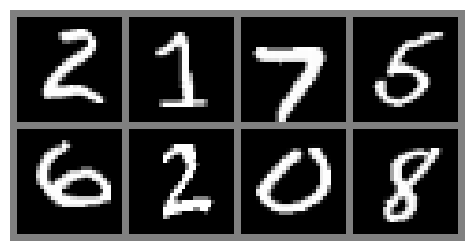

In [ ]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs / nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    plt.show()
    plt.close()


show_imgs([train_set[i][0] for i in range(8)])

In [ ]:
class MaskedConvolution(nn.Module):
    def __init__(self, c_in, c_out, mask, **kwargs):
        super().__init__()

        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]

        padding = tuple([dilation * (kernel_size[i] - 1) // 2 for i in range(2)])

        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)

        self.register_buffer("mask", mask[None, None])

    def forward(self, x):
        self.conv.weight.data *= self.mask
        return self.conv(x)


class VerticalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size // 2 + 1 :, :] = 0

        if mask_center:
            mask[kernel_size // 2, :] = 0

        super().__init__(c_in, c_out, mask, **kwargs)


class HorizontalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(1, kernel_size)
        mask[0, kernel_size // 2 + 1 :] = 0

        if mask_center:
            mask[0, kernel_size // 2] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

In [ ]:
inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], requires_grad=True)

In [ ]:
def show_center_recep_field(img, out):
    # Determine gradients
    loss = out[
        0, :, img.shape[2] // 2, img.shape[3] // 2
    ].sum()  # L1 loss for simplicity
    loss.backward(
        retain_graph=True
    )  # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    img_grads = img.grad.abs()
    img.grad.fill_(0)  # Reset grads

    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img > 0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = img[img.shape[0] // 2, img.shape[1] // 2] == 0
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0] // 2, center_pixel.shape[1] // 2, :] = (
            np.array([1.0, 0.0, 0.0, 1.0])
        )
    for i in range(2):
        ax[i].axis("off")
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

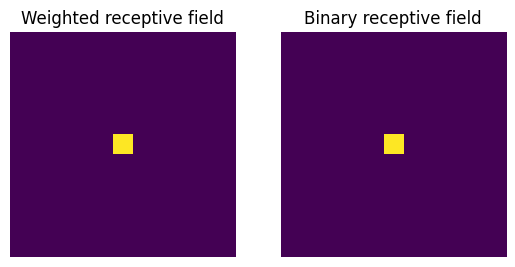

In [ ]:
show_center_recep_field(inp_img, inp_img)

In [ ]:
class GatedMaskedConv(nn.Module):
    def __init__(self, c_in, **kwargs):
        super().__init__()

        self.conv_vert = VerticalStackConvolution(c_in, c_in * 2, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_in * 2, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(
            2 * c_in, 2 * c_in, kernel_size=1, padding=0
        )
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)

    def forward(self, v_stack, h_stack):
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

In [ ]:
class PixelCNN(nn.Module):
    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = nn.ModuleList(
            [
                GatedMaskedConv(c_hidden),
                GatedMaskedConv(c_hidden, dilation=2),
                GatedMaskedConv(c_hidden),
                GatedMaskedConv(c_hidden, dilation=4),
                GatedMaskedConv(c_hidden),
                GatedMaskedConv(c_hidden, dilation=2),
                GatedMaskedConv(c_hidden),
            ]
        )
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)

    def forward(self, x):
        x = (x.float() / 255.0) * 2 - 1

        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)

        for conv in self.conv_layers:
            v_stack, h_stack = conv(v_stack, h_stack)

        # Final output
        out = self.conv_out(F.elu(h_stack))

        out = out.reshape(
            out.shape[0], 256, out.shape[1] // 256, out.shape[2], out.shape[3]
        )
        return out

In [ ]:
def calc_likelihood(model, x):
    pred = model(x)
    nll = F.cross_entropy(pred, x, reduction="none")
    bpd = nll.mean(dim=[1, 2, 3]) * np.log2(np.exp(1))
    return bpd.mean().item()

In [ ]:
model = PixelCNN(1, 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)

In [ ]:
@torch.no_grad()
def sample(model, img_shape, img=None):
    model.eval()

    if img is None:
        img = torch.zeros(img_shape, dtype= torch.long).to(device) - 1

    for h in tqdm(range(img_shape[2]), leave = False):
        for w in range(img_shape[3]):
            for c in range(img_shape[1]):
                if (img[:, c, h, w] != -1).all().item():
                    continue

                pred = model(img[:, :, :h + 1, :])
                probs = F.softmax(pred[:, :, c, h, w]. dim = -1)
                img[:, c, h, w] = torch.multinomial(probs, 1).squeeze(dim = -1)

    return img

In [ ]:
for epoch in range(60):
    for batch in train_loader:
        model.train()
        optimizer.zero_grad()

        batch = batch[0].to(device)
        loss = calc_likelihood(model, batch)
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch + 1} | Loss: {loss:.4f} | BPD: {loss / np.log2(256):.4f}")